In [1]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
load_dotenv()
import os
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"]=OPENAI_API_KEY
openai_model=ChatOpenAI(model="gpt-4o")
openai_model.invoke("hi")

from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

import os
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY="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"
os.environ["TAVILY_API_KEY"]=TAVILY_API_KEY

#### Agent State:

In [2]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

#### Tools -> Single Tool (Web Search using Tavily):

In [3]:
tavily = TavilySearchResults()

In [4]:
tools = [tavily]

#### Bind Tool with LLM:

In [5]:
llm_with_tools = openai_model.bind_tools(tools)

#### AI Assistant:

In [6]:
def ai_assistant(state: AgentState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

#### Memory Saver:

In [7]:
memory = MemorySaver()

#### Graph Builder:

In [8]:
graph_builder = StateGraph(AgentState)
graph_builder.add_node("ai_assistant", ai_assistant)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

#### Workflow:

In [9]:
graph_builder.add_edge(START, "ai_assistant")

graph_builder.add_conditional_edges(
    "ai_assistant",
    tools_condition,
)
graph_builder.add_edge("tools", "ai_assistant")

#### APP:

In [10]:
app2 = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

#### APP Display:

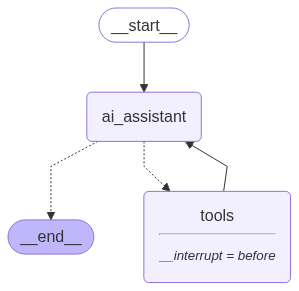

In [11]:

from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

#### User Query Input -> Question:

In [12]:

user_input = "what is current a capital of india?"
config = {"configurable": {"thread_id": "1"}}

#### Stream APP:

In [13]:
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

#### Pretty Print Response:

In [14]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what is current a capital of india?
================================== Ai Message ==================================

The current capital of India is New Delhi.


#### Check Shapshot of the Configuration:

In [15]:
snapshot = app2.get_state(config)

In [16]:
snapshot.next

()

#### Collect the Last Message:

In [17]:
last_message = snapshot.values["messages"][-1]

In [18]:
last_message.tool_calls

[]

#### Stream APP:

In [19]:
events = app2.stream(None, config, stream_mode="values")

#### Pretty Print the Response:

In [20]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()
     

================================== Ai Message ==================================

The current capital of India is New Delhi.


#### Use memeory saver in the question:

In [21]:
user_input = "what is a weather there?"

config = {"configurable": {"thread_id": "1"}}

#### Stream APP:

In [22]:
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

#### Pretty Print the Response:

In [23]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()
     

================================ Human Message =================================

what is a weather there?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_BCOHLAGTu5wbPJodv9RFXPYP)
 Call ID: call_BCOHLAGTu5wbPJodv9RFXPYP
  Args:
    query: current weather in New Delhi


#### Check Snapshot for the Configuration:

In [24]:
snapshot = app2.get_state(config)

#### Check if Snapshot uses Tools or not:

In [25]:
snapshot.next

('tools',)

#### Capture the Last Message:

In [26]:
last_message = snapshot.values["messages"][-1]

In [27]:
last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in New Delhi'},
  'id': 'call_BCOHLAGTu5wbPJodv9RFXPYP',
  'type': 'tool_call'}]

#### Stream APP with NONE:

In [28]:
events = app2.stream(None, config, stream_mode="values")

#### Pretty Print the Response:

In [29]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_BCOHLAGTu5wbPJodv9RFXPYP)
 Call ID: call_BCOHLAGTu5wbPJodv9RFXPYP
  Args:
    query: current weather in New Delhi
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "New Delhi 14 Day Extended Forecast - Weather - Time and Date", "url": "https://www.timeanddate.com/weather/india/new-delhi/ext", "content": "| \\ Updated Friday, August 1, 2025 2:54:29 pm New Delhi time - Weather by CustomWeather, © 2025 | | | | | | | | | | | | | [...] |  | Conditions | | | Comfort | | | | Precipitation | | Sun | | |\n| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |\n| Day |  | Temperature | Weather | Feels Like | Wind |  | Humidity | Chance | Amount | UV | Sunrise | Sunset |\n| Fri Aug 1 |  | 91 / 80 °F | Passing showers. Cloudy. | 107 °F | 10 mph | ↑ | 73% | 76% | 0.36\" | 5

#### Memory Saver Current State Configuration:

In [30]:
app2.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='what is current a capital of india?', additional_kwargs={}, response_metadata={}, id='42620944-4fad-404f-b2f3-d8d9b25b5187'), AIMessage(content='The current capital of India is New Delhi.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 87, 'total_tokens': 97, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-Bzj3aXV7isHzRzumLJqo0o9hasBC4', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--c3604934-4745-468a-a234-63de1533c66b-0', usage_metadata={'input_tokens': 87, 'output_tokens': 10, 'total_tokens': 97, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0

#### Snapshot the Configuration:

In [31]:
snapshot=app2.get_state(config)   

In [32]:
snapshot.next

()

#### Next User Query with Memory Saver:

In [33]:
user_input = "give me the recent news there?"

config = {"configurable": {"thread_id": "1"}}

#### Stream APP:

In [34]:
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

#### Pretty Print the Response:

In [35]:

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

give me the recent news there?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_i7EqDgAkuTFzlxJxOpeJG0ja)
 Call ID: call_i7EqDgAkuTFzlxJxOpeJG0ja
  Args:
    query: recent news in New Delhi


#### Snapshot the Configuration:

In [36]:
snapshot=app2.get_state(config)

In [37]:
snapshot.next

('tools',)

#### Capture the Last Message:

In [38]:
current_message = snapshot.values["messages"][-1]

#### Tool Call ID:

In [39]:
current_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_i7EqDgAkuTFzlxJxOpeJG0ja)
 Call ID: call_i7EqDgAkuTFzlxJxOpeJG0ja
  Args:
    query: recent news in New Delhi


In [40]:
tool_call_id = current_message.tool_calls[0]["id"] 

In [41]:
tool_call_id

'call_i7EqDgAkuTFzlxJxOpeJG0ja'

#### Own Message:

In [42]:
from langchain_core.messages import AIMessage, ToolMessage

In [43]:
answer = "it is just related to raining which is happing on daily basis in delhi"

In [44]:
new_messages = [
    ToolMessage(content=answer, tool_call_id=tool_call_id),
    AIMessage(content=answer),
]

In [45]:
app2.update_state(
    config,
    {"messages": new_messages},
)
  

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f06ed35-ec6f-65c0-800a-628007cd3b21'}}

#### New Response:

In [46]:
print(app2.get_state(config).values["messages"][-1:])

[AIMessage(content='it is just related to raining which is happing on daily basis in delhi', additional_kwargs={}, response_metadata={}, id='933a99b6-a2da-422e-956f-84b3bcd8c7ae')]
